In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE
from sbi.utils import BoxUniform
import sbibm
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior

In [4]:
POI_DIM = 2  # parameter of interest
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
NUM_OBS = 10_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 5_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954
REFERENCE = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

PRIOR_LOC = [0, 0]
PRIOR_SIGMA = np.sqrt(2.0), 3*np.sqrt(2.0), 6*np.sqrt(2.0)

TARGET_LOC = ([0, 0], [2.5, 0], [5, 0], [7.5, 0])
TARGET_SIGMA = PRIOR_SIGMA[0]

task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

In [ ]:
with open(f'./results/sbibm_example/power_study_priorsigma{PRIOR_SIGMA[0]:.2f}', 'rb') as f:
    results_strong_prior = pickle.load(f)
with open(f'./results/sbibm_example/power_study_priorsigma{PRIOR_SIGMA[1]:.2f}', 'rb') as f:
    results_mid_prior = pickle.load(f)
with open(f'./results/sbibm_example/power_study_priorsigma{PRIOR_SIGMA[2]:.2f}', 'rb') as f:
    results_weak_prior = pickle.load(f)

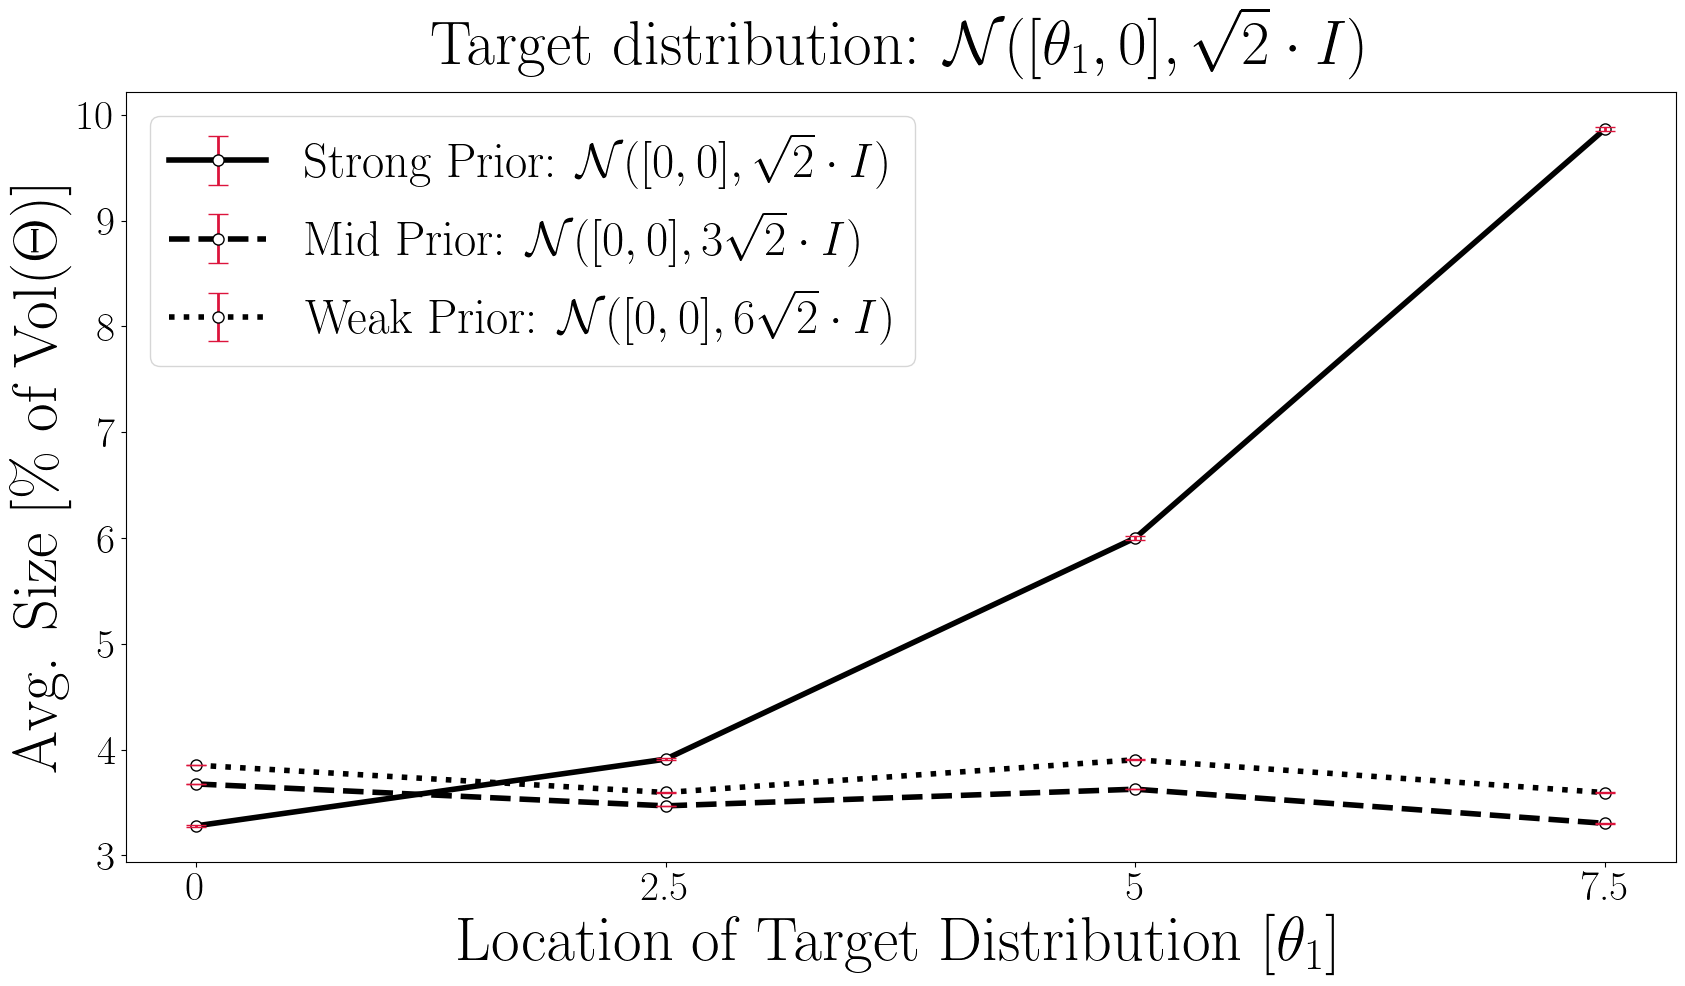

In [55]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
xs = np.array([loc[0] for loc in TARGET_LOC])

# strong prior
confset_sizes_strong = results_strong_prior['confset_sizes']
means_strong = np.array([sizes.mean() for sizes in confset_sizes_strong])
se_strong = np.array([sizes.std(ddof=1) / np.sqrt(len(sizes)) for sizes in confset_sizes_strong])
ax.errorbar(
    xs, means_strong,
    yerr=se_strong,
    fmt='-o',
    color='black',
    markerfacecolor='white',
    ecolor='crimson',
    linewidth=4,
    markersize=8,
    capsize=7,
    elinewidth=2,
    barsabove=True,
    label=r'Strong Prior: $\mathcal{N}([0, 0], \sqrt{2} \cdot I)$'
)

# mid prior
confset_sizes_mid = results_mid_prior['confset_sizes']
means_mid = np.array([sizes.mean() for sizes in confset_sizes_mid])
se_mid = np.array([sizes.std(ddof=1) / np.sqrt(len(sizes)) for sizes in confset_sizes_mid])
ax.errorbar(
    xs, means_mid,
    yerr=se_mid,
    fmt='--o',
    color='black',
    markerfacecolor='white',
    ecolor='crimson',
    linewidth=4,
    markersize=8,
    capsize=7,
    elinewidth=2,
    barsabove=True,
    label=r'Mid Prior: $\mathcal{N}([0, 0], 3\sqrt{2} \cdot I)$'
)

# weak prior
confset_sizes_weak = results_weak_prior['confset_sizes']
means_weak = np.array([sizes.mean() for sizes in confset_sizes_weak])
se_weak = np.array([sizes.std(ddof=1) / np.sqrt(len(sizes)) for sizes in confset_sizes_weak])
ax.errorbar(
    xs, means_weak,
    yerr=se_weak,
    fmt=':o',
    color='black',
    markerfacecolor='white',
    ecolor='crimson',
    linewidth=4,
    markersize=8,
    capsize=7,
    elinewidth=2,
    barsabove=True,
    label=r'Weak Prior: $\mathcal{N}([0, 0], 6\sqrt{2} \cdot I)$'
)


ax.set_xticks([loc[0] for loc in TARGET_LOC])
ax.set_xticklabels([loc[0] for loc in TARGET_LOC])
ax.tick_params(labelsize=30)
ax.set_xlabel(r'Location of Target Distribution [$\theta_1$]', fontsize=45)
ax.set_ylabel(r'Avg. Size [\% of $\text{Vol}(\Theta)$]', fontsize=45)
ax.set_title(r'Target distribution: $\mathcal{N}([\theta_1, 0], \sqrt{2} \cdot I)$', size=45, pad=20)
ax.legend(prop={'size': 35})
plt.show()